# Market-cap vs. Equal Weight

In [14]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(ggthemes)
library(quantmod)
library(PerformanceAnalytics)
library(reshape2)
library(ggrepel)

options(repr.plot.width=16, repr.plot.height=8)

#initialize
indices<-Indices()

In [17]:
indexName1 <- "NIFTY 100 TR"
indexName2 <- "NIFTY100 EQUAL WEIGHT TR"

startDate <- as.Date("2003-01-01")
endDate <- as.Date("2019-11-25")

In [21]:
iPx1 <- indices$NseTimeSeries() %>%
    filter(NAME == indexName1 & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
    select(CLOSE, TIME_STAMP) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

In [22]:
iPxXts1 <- xts(iPx1$CLOSE, iPx1$TIME_STAMP)
iDret1 <- dailyReturn(iPxXts1)
iMret1 <- monthlyReturn(iPxXts1)
iYret1 <- yearlyReturn(iPxXts1)

In [23]:
iPx2 <- indices$NseTimeSeries() %>%
    filter(NAME == indexName2 & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
    select(CLOSE, TIME_STAMP) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

In [24]:
iPxXts2 <- xts(iPx2$CLOSE, iPx2$TIME_STAMP)
iDret2 <- dailyReturn(iPxXts2)
iMret2 <- monthlyReturn(iPxXts2)
iYret2 <- yearlyReturn(iPxXts2)

In [25]:
dailies <- merge(iDret1, iDret2)
names(dailies) <- c('Market Cap', 'Equal')
dailies <- na.omit(dailies)

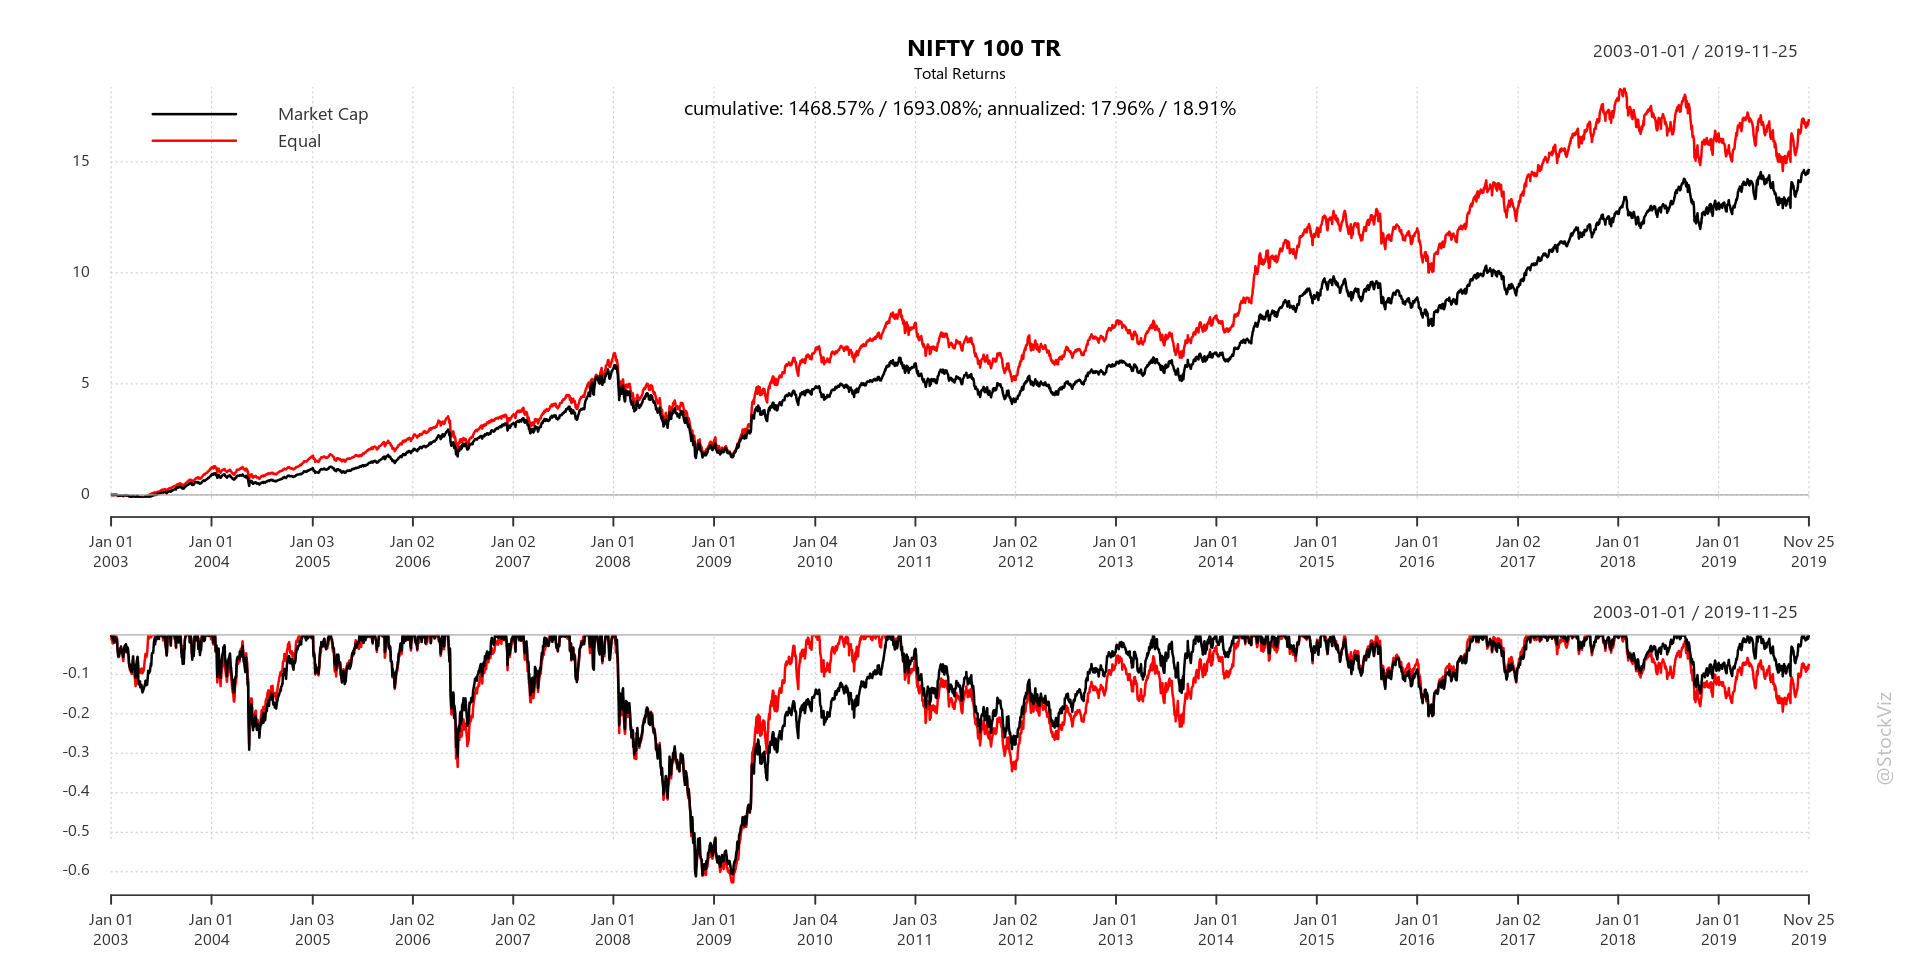

In [26]:
Common.PlotCumReturns(dailies, indexName1, "Total Returns")

In [27]:
yearlies <- merge(iYret1, iYret2)
names(yearlies) <- c('Market Cap', 'Equal')
yearlies <- na.omit(yearlies)

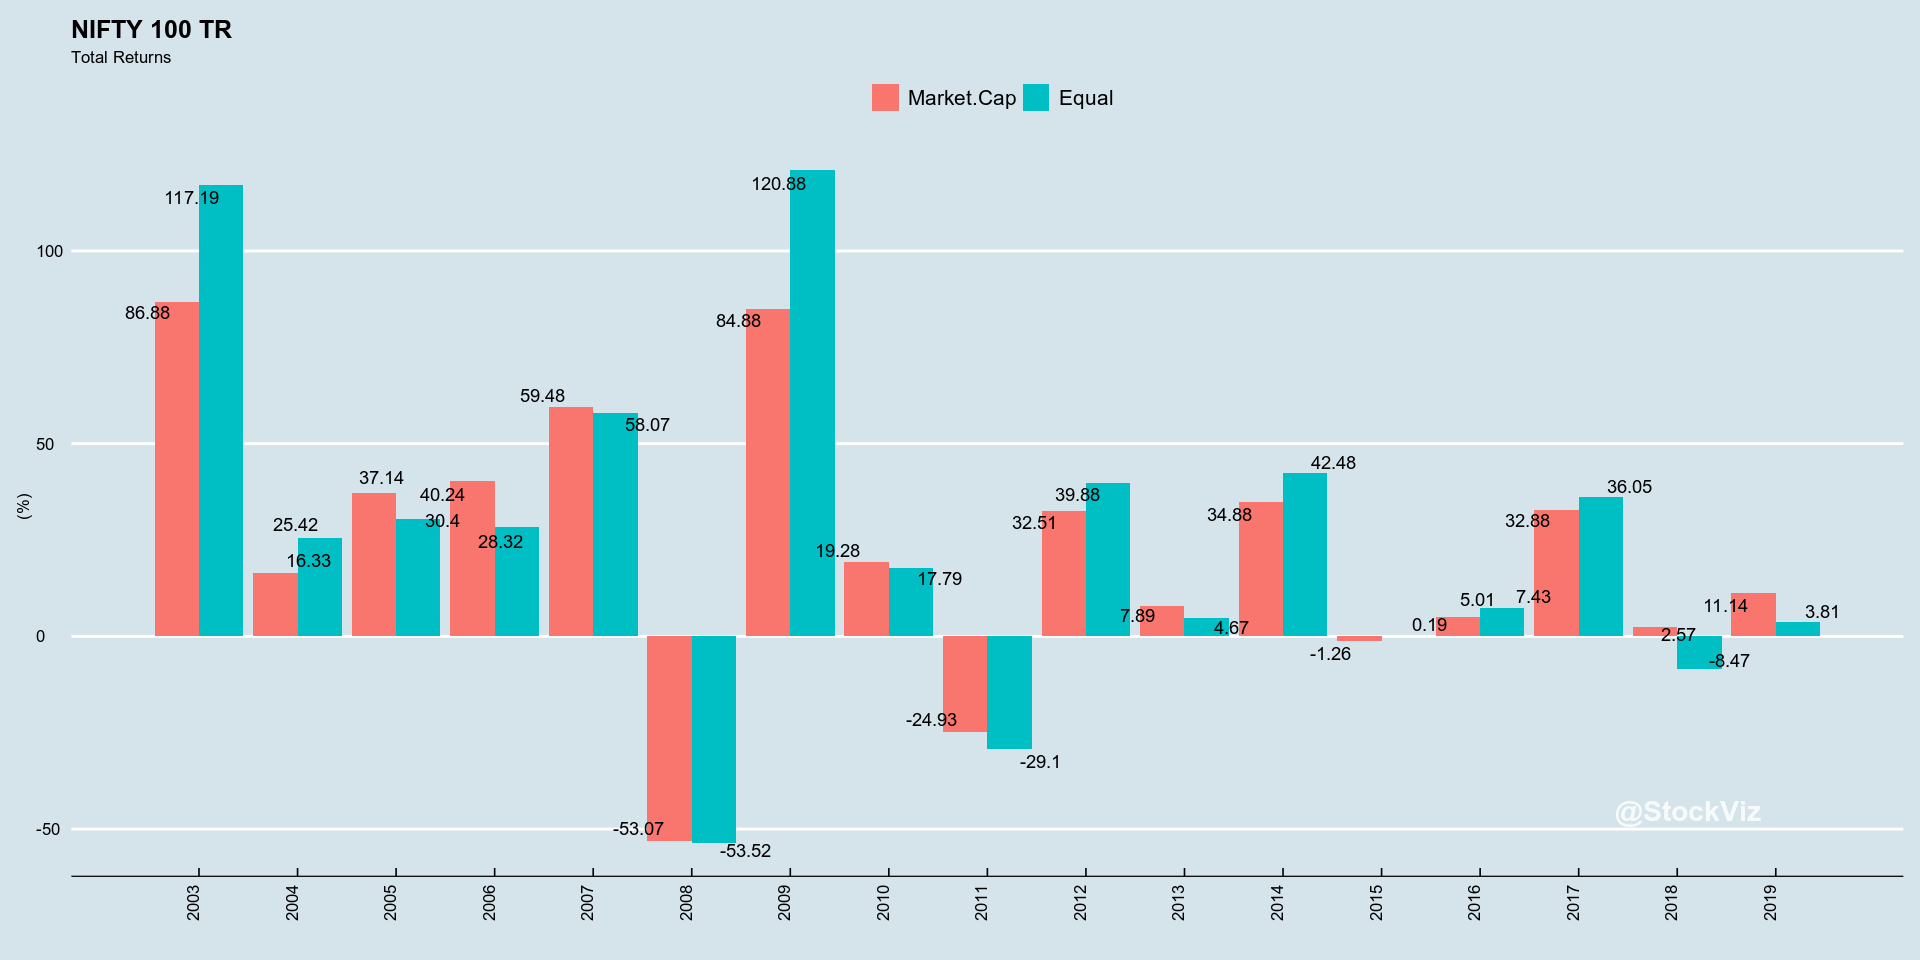

In [28]:
toPlot <- data.frame(100*yearlies)
toPlot$YEAR <- year(index(yearlies))
mDf <- melt(toPlot, id='YEAR')
ggplot(mDf, aes(x=YEAR, y=value, fill=variable)) +
    theme_economist() +
    theme(axis.text.x=element_text(angle=90, hjust=1)) +
    geom_bar(stat="identity", position=position_dodge()) +
    scale_x_continuous(labels=toPlot$YEAR, breaks=toPlot$YEAR) +
    geom_text_repel(aes(label= round(value, 2)), position = position_dodge(0.9)) +
    labs(x='', y='(%)', fill='', title=indexName1, subtitle="Total Returns") +
    annotate("text", x=max(toPlot$YEAR), y=min(mDf$value), 
             label = "@StockViz", hjust=1.1, vjust=-1.1, 
             col="white", cex=6, fontface = "bold", alpha = 0.8)  

In [40]:
monthlies <- merge(iMret1, iMret2)
#on a rolling YR-year basis, how many months did equal weight out-perform market weight?
YR <- 5 #years
lookback <- YR * 12 #months
eqGtMktMonthly <- ifelse(monthlies[,2] > monthlies[,1], 1, 0)

eqGtMkt <- rollapply(eqGtMktMonthly, lookback, sum)
eqGtMkt <- na.omit(eqGtMkt)

#on a rolling YR-year basis, what was the difference in returns between equal-weight and market weight?
eqMinusMkt <- rollapply(monthlies, lookback, function(X) {
    Return.cumulative(X[,2]) - Return.cumulative(X[,1])
}, by.column = F)

eqMinusMkt <- na.omit(eqMinusMkt)

In [41]:
plotLine <- function(dXts, mainTitle, subTitle){
    mDf <- data.frame(dXts)
    names(mDf) <- c('V')
    mDf$T <- index(eqGtMkt)
    ggplot(mDf, aes(x=T, y=V)) +
        theme_economist() +
        geom_line() + 
        labs(x='', y='', fill='', title=mainTitle, subtitle=subTitle) +
        annotate("text", x=max(mDf$T), y=min(mDf$V), 
             label = "@StockViz", hjust=1.1, vjust=-1.1, 
             col="white", cex=6, fontface = "bold", alpha = 0.8)
}

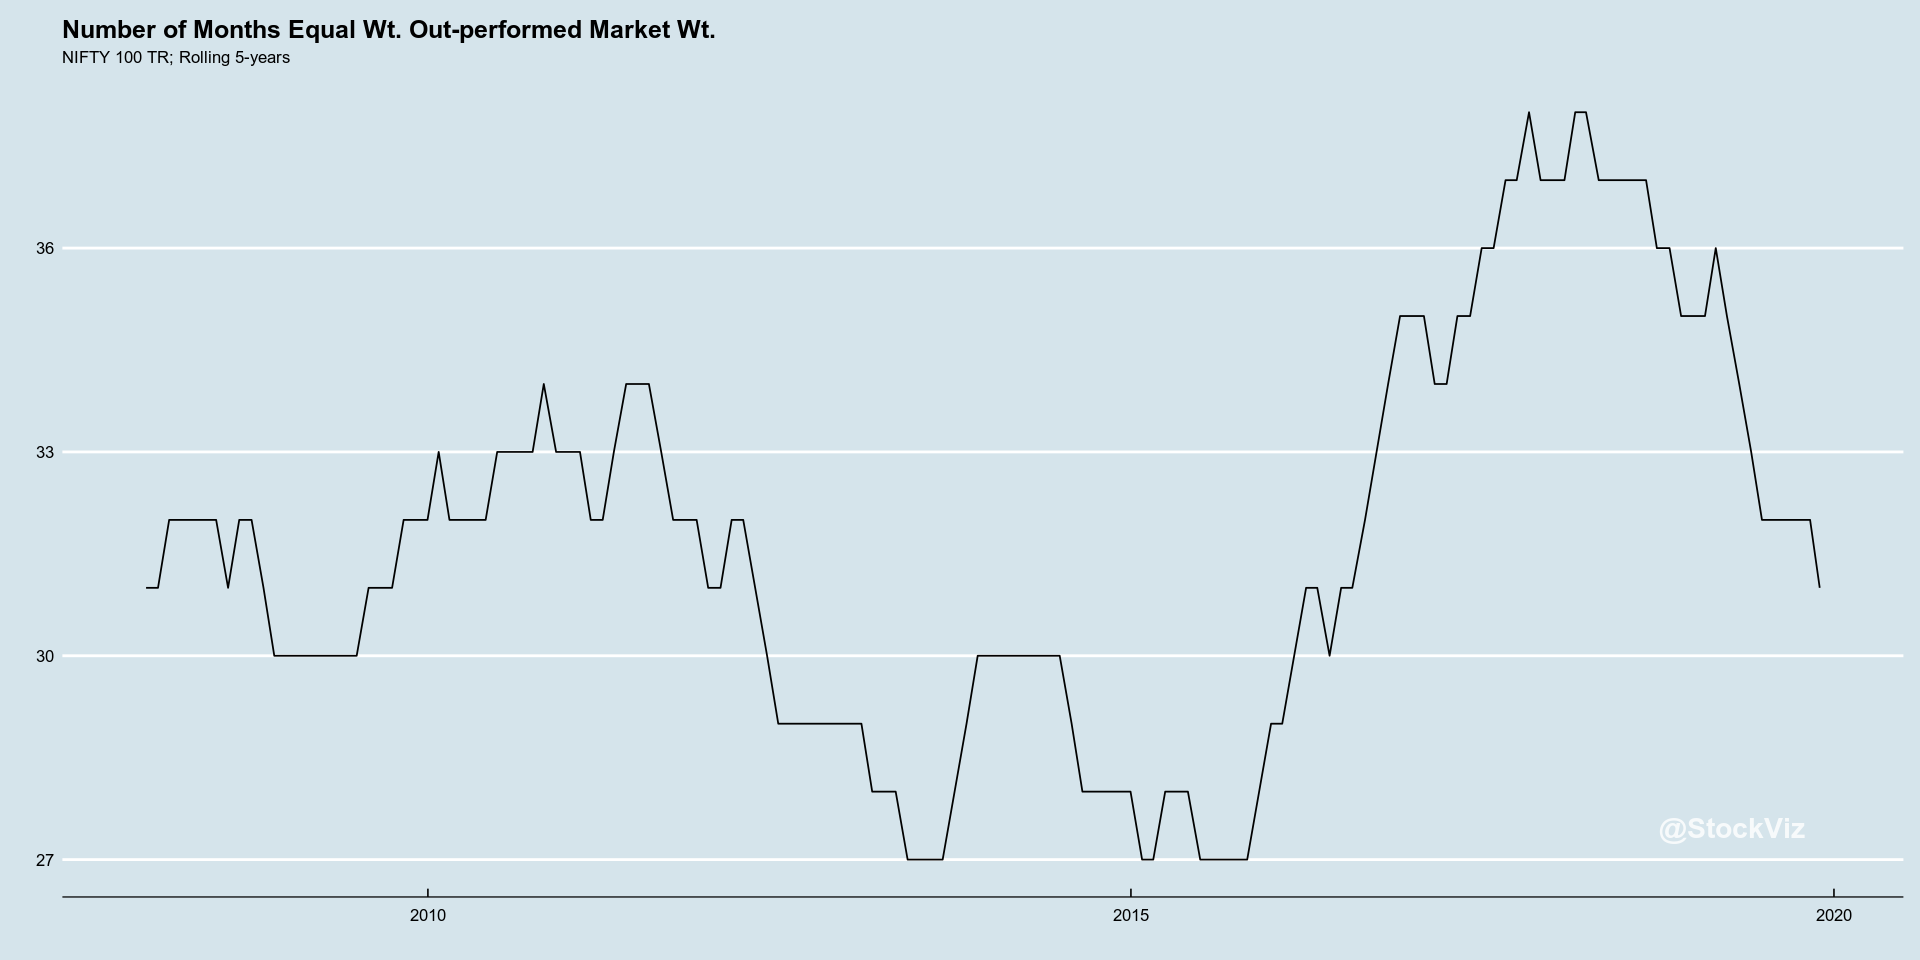

In [42]:
plotLine(eqGtMkt, "Number of Months Equal Wt. Out-performed Market Wt.", sprintf("%s; Rolling %d-years", indexName1, YR))

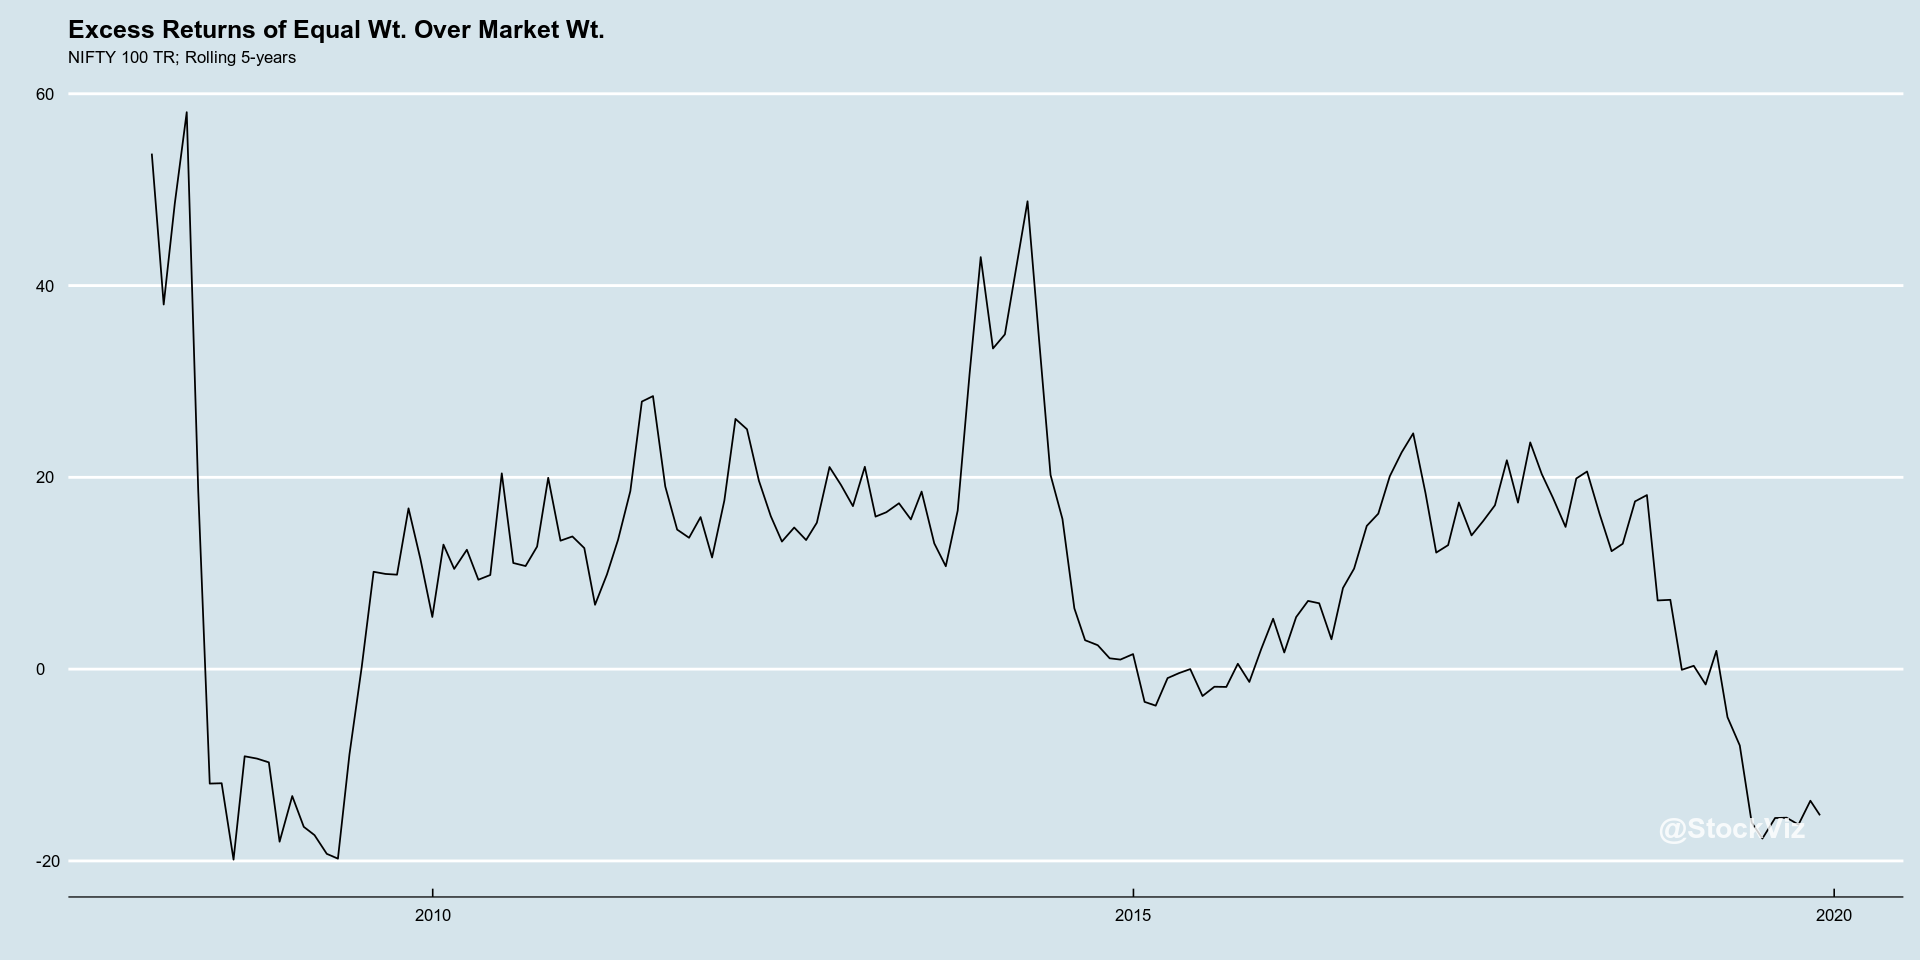

In [43]:
plotLine(100*eqMinusMkt, "Excess Returns of Equal Wt. Over Market Wt.", sprintf("%s; Rolling %d-years", indexName1, YR))

In [44]:
print("Market weight summary stats:")
print(summary(monthlies[,1]))
print("std-dev:")
print(sd(monthlies[,1]))
print("Equal weight summary stats:")
print(summary(monthlies[,2]))
print("std-dev:")
print(sd(monthlies[,2]))

[1] "Market weight summary stats:"
     Index            monthly.returns   
 Min.   :2003-01-31   Min.   :-0.26715  
 1st Qu.:2007-04-14   1st Qu.:-0.01516  
 Median :2011-06-30   Median : 0.01418  
 Mean   :2011-06-30   Mean   : 0.01584  
 3rd Qu.:2015-09-15   3rd Qu.: 0.05376  
 Max.   :2019-11-25   Max.   : 0.29938  
[1] "std-dev:"
[1] 0.06608624
[1] "Equal weight summary stats:"
     Index            monthly.returns.1 
 Min.   :2003-01-31   Min.   :-0.27963  
 1st Qu.:2007-04-14   1st Qu.:-0.02030  
 Median :2011-06-30   Median : 0.01891  
 Mean   :2011-06-30   Mean   : 0.01704  
 3rd Qu.:2015-09-15   3rd Qu.: 0.05823  
 Max.   :2019-11-25   Max.   : 0.40891  
[1] "std-dev:"
[1] 0.07442534


In [45]:
ir <- rollapply(monthlies, lookback, function(X) InformationRatio(X[,2], X[,1]), by.column = F) 

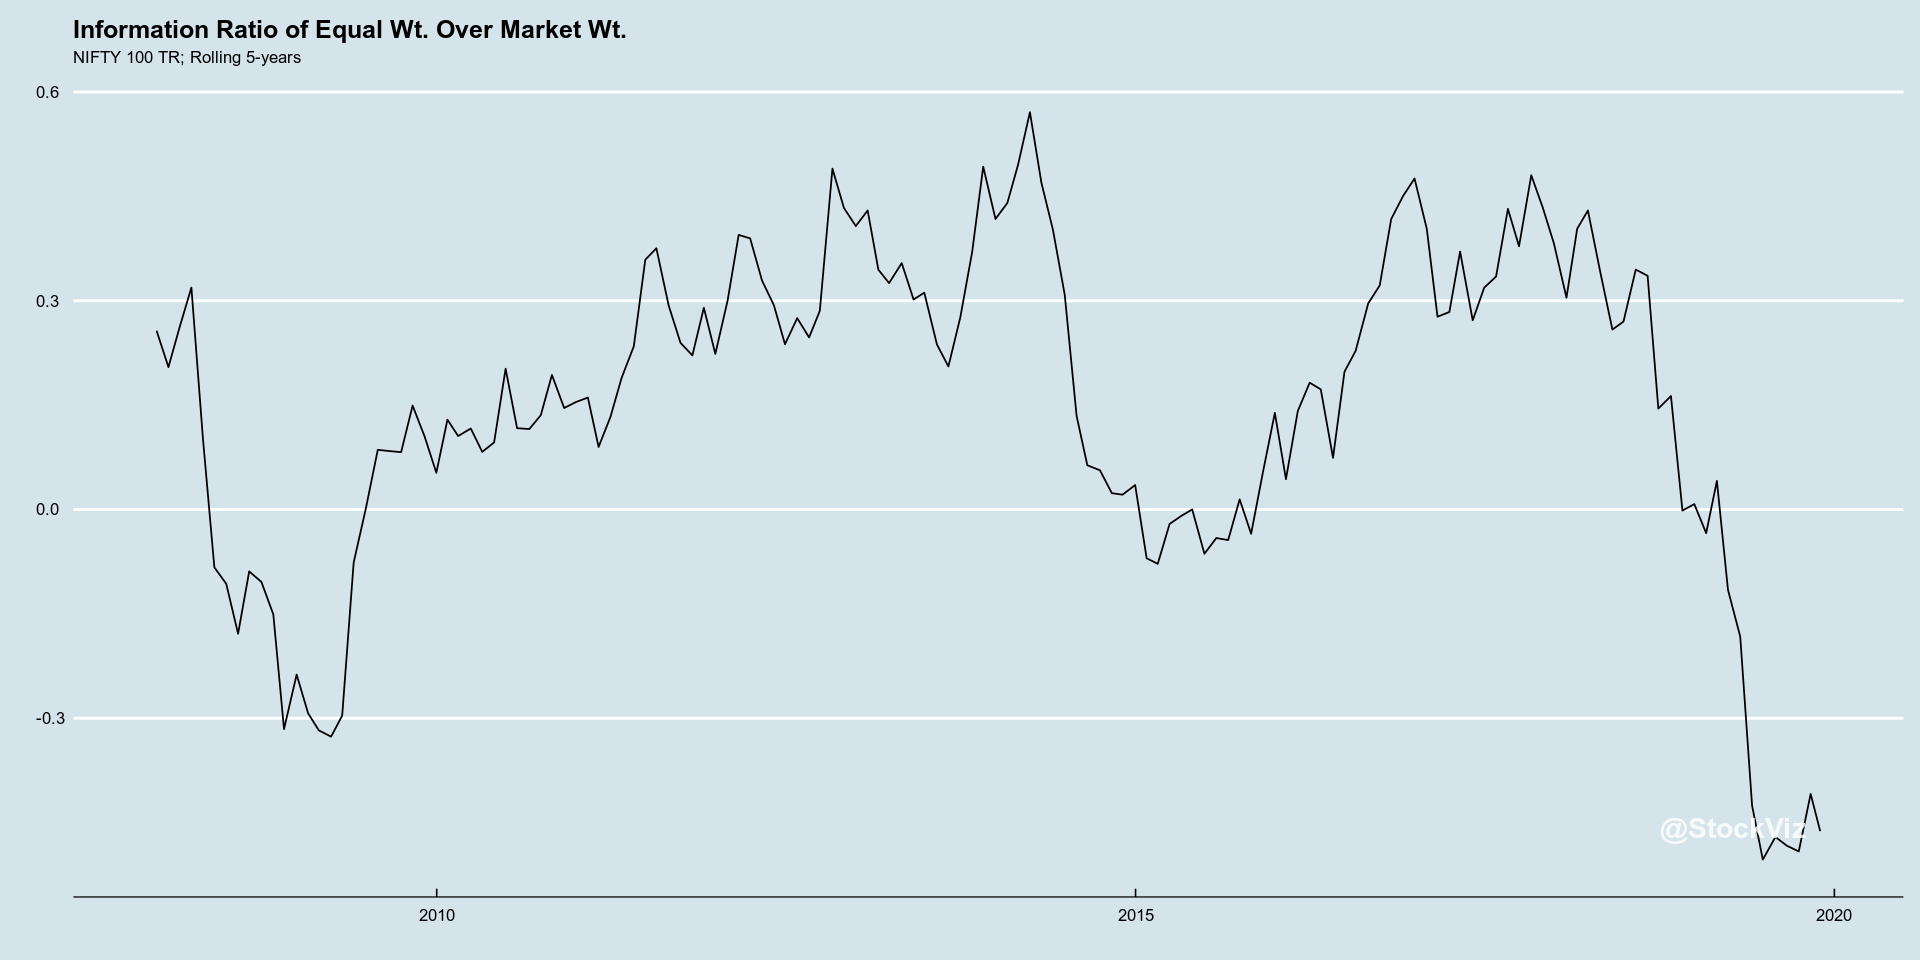

In [46]:
ir <- na.omit(ir)
plotLine(ir, "Information Ratio of Equal Wt. Over Market Wt.", sprintf("%s; Rolling %d-years", indexName1, YR))

This notebook was created using [pluto](https://pluto.studio). Thank you for playing fair!